In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from langchain_huggingface import HuggingFaceEmbeddings
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
import warnings
warnings.filterwarnings("ignore", message="Your application has authenticated using end user credentials")


from google.cloud import bigquery;
%load_ext google.cloud.bigquery

client = bigquery.Client("som-nero-phi-jonc101")

pd.set_option('display.max_columns', None)

import requests
import json
from dotenv import load_dotenv
load_dotenv()
import os


The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [2]:
data_path = "/Users/wenyuanchen/Library/CloudStorage/Box-Box/ART_PerMessage_1_17_Updated.xlsx"
data_sample = pd.read_excel(data_path)  # or whatever number of rows you want # take around 6 minutes to run 
# data_sample["Patient Message"] = data_sample["Patient Message"].replace("<13><10>", "\n")
# data_sample["Actual Response Sent to Patient"] = data_sample["Actual Response Sent to Patient"].replace("<13><10>", "\n").fillna("No response")

# This notebook only explroes three specilaties: primary care, internal medicine and family medicine. 
#  Only ncludes threads with response from provider
# Only includes threads with a prompt sent to LLM

In [15]:
data_sample.head(5)

,Source.Name,EOW ID,Reply to Patient EOW ID,WMG ID,Thread ID,Date Sent,Message Department,Department Specialty Title,Department Specialty Category,Reply to Patient Sender,Reply to Patient User Template,Reply to Patient User Licenses,Reply to Patient Provider Type,Message Sender,Recipient IDs,Recipient Names,Recipient Licenses,LLM Viewer IDs,LLM Viewer Names,LLM Viewer Licenses,Is Response Valid?,Prompt Sent to LLM,Suggested Response from LLM,Response If Used As Draft,Actual Response Sent to Patient,List of Strings Removed from Draft,List of Strings Added to Draft,Total Length of Removed Strings,Total Length of Added Strings,Length of Draft Unchanged,Subject,Time Spent Responding (sec),Time Spent Reading (sec),Draft Viewed By Pilot User,Draft Used By Pilot User,Command Executed,QuickAction Executed,Levenshtein Distance,Response Length,Draft Length,Prompt Length,Subject Length,Patient Message Length,Patient Message,LLM Feedback,LLM Feedback Deficiencies,LLM Feedback Comment,LLM Feedback User,Clinical Categories added by User,Non-Clinical Categories added by User,Non-Actionable Categories added by User,Clinical Categories added by System,Non-Clinical Categories added by System,Non-Actionable Categories added by System,Age at time of message,Sex Title,Sex Category,Gender Category,Gender Title,Race Title,Race Category,Ethnic Background Title,Ethnic Background Category,Ethnic Group Title,Ethnic Group Category,Financial Class Title,Financial Class Category,Active Coverages Title,Active Coverages Category,Preferred Language Title,Preferred Language Category,Need Interpreter? Title EPT-840,Need Interpreter? Cat EPT-840,Patient Has MyChart Proxies?,Completed Data Models,Message Position in Thread,Hours Between Current and Previous Message
0,LLMData_1.csv,901410967,NaN,92586871,255729942,2025-01-16,THORACIC ONCOLOGY,Oncology,24,NaN,NaN,NaN,NaN,"TRAN, TRI [ S0372371]",POOL 10419,CC THOR ONC MED CLINICAL,NaN,NaN,NaN,NaN,1,Act as if you are the Healthcare Provider who ...,"Hi Judy,<10><10>It's great to hear that Adam i...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,RE:Labs,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,10045,7,298,"Hi Marilena,<13><10><13><10>I was asking more ...",NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,59.0,Male,2.0,NaN,NaN,Asian,8,"Chinese, except Taiwanese",11,Non-Hispanic/Non-Latino,2.0,NaN,NaN,MANAGED CARE,101.0,English,132.0,No,2.0,0,NaN,1.0,NaN
1,LLMData_1.csv,901410953,NaN,92586638,255891686,2025-01-16,STANFORD PRIMARY CARE SANTA CLARA,Primary Care,125,NaN,NaN,NaN,NaN,"ROGACION, JOSE ANTONIO [ S0294361]",POOL 10849,SANTA CLARA PRIMARY CARE TASK POOL TEAM 2,NaN,NaN,NaN,NaN,1,Act as if you are the Healthcare Provider who ...,"Hi Julie,<10><10>Thank you for forwarding the ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,Scheduling Question,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,3700,19,697,"Hi, Dr. Liz; I received the letter below regar...",NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,52.0,Female,1.0,NaN,NaN,White,6,American,53,Non-Hispanic/Non-Latino,2.0,NaN,NaN,MANAGED CARE,101.0,English,132.0,No,2.0,0,NaN,1.0,NaN
2,LLMData_1.csv,901410929,NaN,92588354,254845765,2025-01-16,THORACIC ONCOLOGY,Oncology,24,NaN,NaN,NaN,NaN,"TRAN, TRI [ S0372371]",S0004609,"OJASCASTRO, LLOYD",MA,NaN,NaN,NaN,1,Act as if you are the Healthcare Provider who ...,"Rosemary, <10><10>You should follow-up with yo...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,RE: Test Results Question,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,3112,25,130,Great please let me know as soon as possible ....,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,NaN,NaN,64.0,Female,1.0,NaN,NaN,Black or African American,2,African American/Black,21,Non-Hispanic/Non-Latino,2.0,NaN,NaN,MEDI-CAL,300.0,English,132.0,No,2.0,0,NaN,1.0,NaN
3,LLMData_1.csv,901410919,NaN,92589928,255900067,2025-01-16,FAMILY MEDICINE SAMARITAN LOS GATOS,Family Medicine,9,NaN,NaN,NaN,NaN,"DELGADO, NICOLE [ S0367163]",S0100823,"SHAH, RINA BIREN",MD<13><10>MD,NaN,NaN,NaN,1,Act as if you are the Healthcare Provider who ...,"Yes, Anne. Please make an appointment to discu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [52]:
assert len(data_sample.columns) == 77 
helpful_cols = ["Thread ID","Date Sent",
                                 "Subject","Patient Message", "Message Sender",
                                 "Actual Response Sent to Patient",
                                 "Recipient Names","Recipient IDs", "Message Department","Department Specialty Title", "Prompt Sent to LLM", "Suggested Response from LLM", "QuickAction Executed"]
data_sample_sub_cols = data_sample[helpful_cols]


NameError: name 'data_sample' is not defined

In [19]:
# To-do:I need the code sheet to understand the quickaction executed
data_sample_sub_cols["QuickAction Executed"].unique()

array([    nan,  20000., 141061., 113570., 132484., 132043., 126580.,
       153453., 132978., 149534., 155537., 143763., 143635., 133040.,
       141414., 133156., 117735., 120036., 153103., 153017., 152213.,
       138906., 125452., 120069., 119388., 154618., 144700., 129721.,
       118688., 153921., 121582., 112689., 119799., 136018., 133235.,
       138904., 101177., 138909., 113455., 120549., 101176., 112653.,
       143896., 134783., 144699., 132995., 147934., 137981., 120046.,
       127069., 143789., 147554., 143819., 150433., 132958., 126191.,
       112760., 139891., 120042., 154651., 116273., 125087., 121667.,
       119098., 143714., 132297., 138903., 127531., 120070., 120055.,
       147549., 152790., 121224., 155595., 154717., 119099., 113479.,
       132772., 133207., 133243., 131658., 138902., 138908., 133378.,
       153102., 146750., 128070., 118686., 138927., 117858., 138887.,
       152603., 138774., 145095., 138911., 155219., 133043., 130107.,
       143818., 1324

In [47]:
# # keep only primary care, internal medicine and family medicine
# interested_specialties = ["Primary Care", "Internal Medicine", "Family Medicine"]
# data_sample_sub_cols = data_sample_sub_cols[data_sample_sub_cols["Department Specialty Title"].isin(interested_specialties)]
# assert len(data_sample_sub_cols["Department Specialty Title"].unique()) == 3
# # keep only threads with prompt and response
# data_sample_sub_cols_has_prompt = data_sample_sub_cols[data_sample_sub_cols["Prompt Sent to LLM"].notnull()]
# data_sample_sub_cols_has_prompt_and_response = data_sample_sub_cols_has_prompt[data_sample_sub_cols_has_prompt["Actual Response Sent to Patient"].notnull()]

In [116]:
def remove_duplicate_messages(threads_to_keep):
    # first round of duplicate removal
    df = data_sample_sub_cols[data_sample_sub_cols['Thread ID'].isin(threads_to_keep)].reset_index().sort_values(['Thread ID', 'index'], ascending=False).drop_duplicates()
 
    # Create a boolean column: True if response exists, False otherwise
    df['has_response'] = df["Actual Response Sent to Patient"].notnull()

    # Sort so that for each Patient Message, rows with a response come first, then by index (descending or ascending as you prefer)
    df = df.sort_values(['Patient Message', 'has_response', 'index'], ascending=[True, False, False])

    # Drop duplicates based on Patient Message, keeping the one with a response if it exists
    df_no_dupes = df.drop_duplicates(subset=["Patient Message"], keep='first').sort_values(['Thread ID', 'index'], ascending=False)

    # Optionally, drop the helper column
    df_no_dupes = df_no_dupes.drop(columns=['has_response'])
    return df_no_dupes


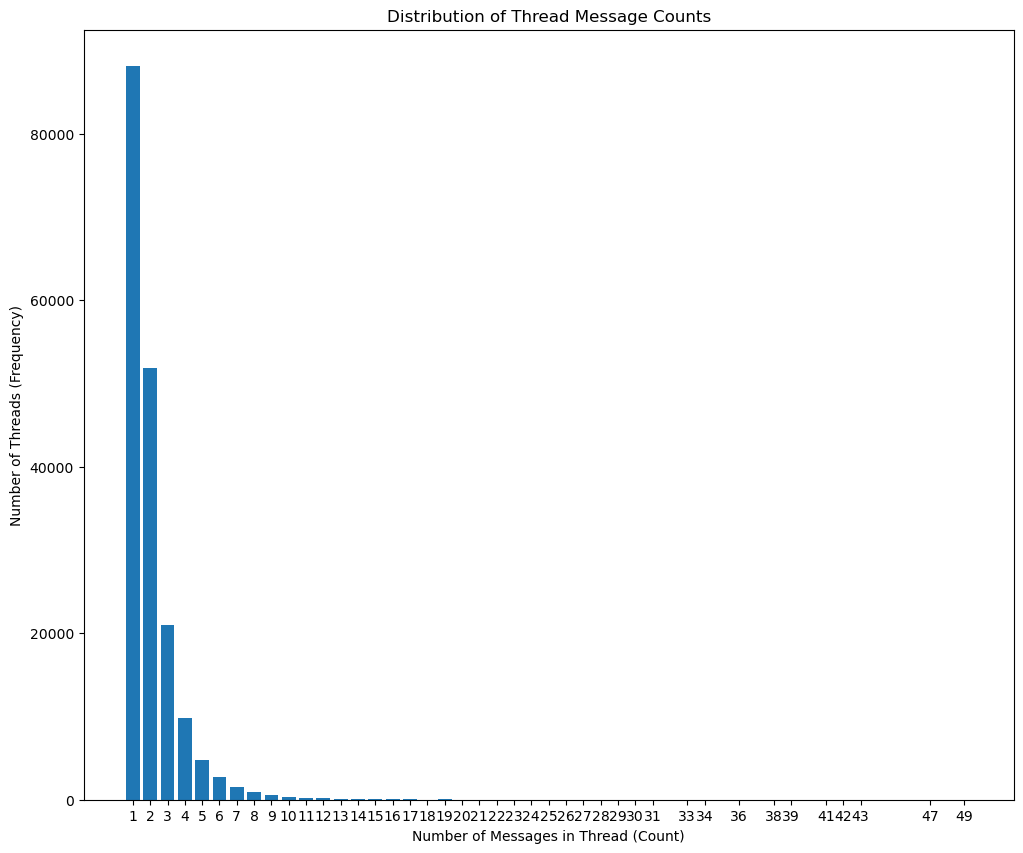

the number of threads is 182698
the number of messages is 375933
 the average number of messages per thread is 2.0576744135130105


In [117]:
# Get the count of each Thread ID
# Filter out rows where patient message and actual response are not present
threads_to_keep = data_sample_sub_cols[data_sample_sub_cols["Actual Response Sent to Patient"].notna()]["Thread ID"].unique()
answer_question_paired_data_dedup = remove_duplicate_messages(threads_to_keep = threads_to_keep).dropna(subset=["Patient Message"]) # the main df for embedding
answer_question_paired_data_dedup["Patient Message"] = answer_question_paired_data_dedup["Patient Message"].str.replace("<13><10>", "")
answer_question_paired_data_dedup["Actual Response Sent to Patient"] = answer_question_paired_data_dedup["Actual Response Sent to Patient"].str.replace("<13><10>", "")
thread_counts_with_response = answer_question_paired_data_dedup['Thread ID'].value_counts()

# Now, get the frequency of each count (i.e., how many threads have count=1, count=2, etc.)
count_frequency_with_response = thread_counts_with_response.value_counts().sort_index()

# Plot
plt.figure(figsize=(12,10))
plt.bar(count_frequency_with_response.index, count_frequency_with_response.values)
plt.xlabel('Number of Messages in Thread (Count)')
plt.ylabel('Number of Threads (Frequency)')
plt.title('Distribution of Thread Message Counts')
plt.xticks(count_frequency_with_response.index)  # Show all counts on x-axis if not too many
plt.show()
print(f"the number of threads is {len(thread_counts_with_response)}")
print(f"the number of messages is {thread_counts_with_response.sum()}")
print(f" the average number of messages per thread is {thread_counts_with_response.mean()}")

In [ ]:
# save the df to local to avoid re-run the code
# answer_question_paired_data_dedup.to_excel("../data/answer_question_paired_data_dedup.xlsx", index=True)


In [29]:
# def beautiful_print_thread(thread_id = None, df = answer_question_paired_data_dedup):
#     if thread_id is None:
#         thread_id =np.random.choice(df["Thread ID"].unique())
#     # sort by index is important to make sure the message is in the correct order
#     thread_df = df[df["Thread ID"] == thread_id].sort_index(ascending=False)
#     print(f"Thread ID: {thread_id}")
#     print("-" * 80)
#     for idx, row in thread_df.iterrows():
#         print(f"idx: {idx}")
#         print(f"Subject: {row['Subject']}")
#         print("-" * 40)
#         print(f"Date Sent: {row['Date Sent']}")
#         print("-" * 40)
#         print("Sender Message:")
#         print(row["Patient Message"].replace("<13><10>", "\n"))
#         print("-" * 40)
#         print(f"Provider Response by {row["Recipient Names"]}:")
#         try:
#             print(row["Actual Response Sent to Patient"].replace("<13><10>", "\n"))
#         except:
#             print("No response")
#         print("-" * 40)  # Separator for readability
answer_question_paired_data_dedup = pd.read_excel("../data/answer_question_paired_data_dedup.xlsx")
def beautiful_print_thread(thread_id = None, df = answer_question_paired_data_dedup):
    if thread_id is None:
        thread_id = np.random.choice(df["Thread ID"].unique())
    # sort by index is important to make sure the message is in the correct order
    thread_df = df[df["Thread ID"] == thread_id].sort_index(ascending=False)
    
    # Build the output string instead of printing
    output = []
    output.append(f"Thread ID: {thread_id}")
    output.append("-" * 80)
    for idx, row in thread_df.iterrows():
        output.append(f"idx: {idx}")
        output.append(f"Subject: {row['Subject']}")
        output.append("-" * 40)
        output.append(f"Date Sent: {row['Date Sent']}")
        output.append("-" * 40)
        output.append("Sender Message:")
        output.append(row["Patient Message"].replace("<13><10>", "\n"))
        output.append("-" * 40)
        output.append(f"Provider Response by {row['Recipient Names']}:")
        try:
            output.append(row["Actual Response Sent to Patient"].replace("<13><10>", "\n"))
        except:
            output.append("No response")
        output.append("-" * 40)  # Separator for readability
    
    # Join all lines with newlines and return
    return "\n".join(output)

#### embedding starts

In [2]:
def create_embeddings():
    embeddings = HuggingFaceEmbeddings(
        model_name="sentence-transformers/all-mpnet-base-v2"
    )
    return embeddings
embeddings_model = create_embeddings()

In [122]:
# # Create embeddings for all texts
# texts = answer_question_paired_data_dedup["Patient Message"].str.replace("<13><10>", "").tolist()
# embeddings = embeddings_model.embed_documents(texts)
# # Save embeddings
# np.save("../data/embeddings.npy", np.array(embeddings))
# answer_question_paired_data_dedup["embeddings"] = embeddings
# # Make sure the embeddings column is a list of float64 per row
# answer_question_paired_data_dedup["embeddings"] = answer_question_paired_data_dedup["embeddings"].apply(lambda x: [float(val) for val in x])

In [ ]:
answer_question_paired_data_dedup = pd.read_excel("../data/answer_question_paired_data_dedup.xlsx")
embeddings = np.load("../data/embeddings.npy")
answer_question_paired_data_dedup["embeddings"] = [emb for emb in embeddings]
# # Make sure the embeddings column is a list of float64 per row
answer_question_paired_data_dedup["embeddings"] = answer_question_paired_data_dedup["embeddings"].apply(lambda x: [float(val) for val in x])


In [11]:
# # dataset_id = "rag_embedding_R01"
# # dataset_ref = client.dataset(dataset_id)

# # # Create the dataset
# # dataset = bigquery.Dataset(dataset_ref)
# # dataset.location = "US" 

# # client.create_dataset(dataset, exists_ok=True)
# # print(f"✅ Created dataset: {dataset_id}")

# # upload the embedding with meta data to gcp big query
# table_id = "som-nero-phi-jonc101.rag_embedding_R01.messages_with_embeddings_updated"

# schema = [
#     bigquery.SchemaField("index", "INT64"),
#     bigquery.SchemaField("Thread ID", "INT64"),
#     bigquery.SchemaField("Date Sent", "TIMESTAMP"),
#     bigquery.SchemaField("Subject", "STRING"),
#     bigquery.SchemaField("Patient Message", "STRING"),
#     bigquery.SchemaField("Message Sender", "STRING"),
#     bigquery.SchemaField("Actual Response Sent to Patient", "STRING"),
#     bigquery.SchemaField("Recipient Names", "STRING"),
#     bigquery.SchemaField("Recipient IDs", "STRING"),
#     bigquery.SchemaField("Message Department", "STRING"),
#     bigquery.SchemaField("Department Specialty Title", "STRING"),
#     bigquery.SchemaField("Prompt Sent to LLM", "STRING"),
#     bigquery.SchemaField("Suggested Response from LLM", "STRING"),
#     bigquery.SchemaField("QuickAction Executed", "INT64"),

#     bigquery.SchemaField("embeddings", "FLOAT64", mode="REPEATED")
    
# ]

# job_config = bigquery.LoadJobConfig(
#     schema=schema,
#     write_disposition="WRITE_TRUNCATE",
#     clustering_fields=["Recipient Names", "Message Department", "Department Specialty Title"]
# )

# job = client.load_table_from_dataframe(answer_question_paired_data_dedup, table_id, job_config=job_config)
# job.result()

# print("✅ Upload complete with clustering.")

# upload the embedding with meta data to gcp big query
table_id = "som-nero-phi-jonc101.rag_embedding_R01.messages_with_embeddings_updated"

schema = [
    bigquery.SchemaField("index", "INT64"),
    bigquery.SchemaField("Thread ID", "INT64"),
    bigquery.SchemaField("Date Sent", "TIMESTAMP"),
    bigquery.SchemaField("Subject", "STRING"),
    bigquery.SchemaField("Patient Message", "STRING"),
    bigquery.SchemaField("Message Sender", "STRING"),
    bigquery.SchemaField("Actual Response Sent to Patient", "STRING"),
    bigquery.SchemaField("Recipient Names", "STRING"),
    bigquery.SchemaField("Recipient IDs", "STRING"),
    bigquery.SchemaField("Message Department", "STRING"),
    bigquery.SchemaField("Department Specialty Title", "STRING"),
    bigquery.SchemaField("Prompt Sent to LLM", "STRING"),
    bigquery.SchemaField("Suggested Response from LLM", "STRING"),
    bigquery.SchemaField("QuickAction Executed", "INT64"),
    bigquery.SchemaField("embeddings", "FLOAT64", mode="REPEATED")
]

# Define batch size
BATCH_SIZE = 10000  # Adjust this number based on your memory constraints

# Process in batches
for i in range(0, len(answer_question_paired_data_dedup), BATCH_SIZE):
    batch_df = answer_question_paired_data_dedup.iloc[i:i+BATCH_SIZE]
    
    job_config = bigquery.LoadJobConfig(
        schema=schema,
        write_disposition="WRITE_APPEND" if i > 0 else "WRITE_TRUNCATE",  # Append after first batch
        clustering_fields=["Recipient Names", "Message Department", "Department Specialty Title"]
    )
    
    job = client.load_table_from_dataframe(batch_df, table_id, job_config=job_config)
    job.result()
    print(f"✅ Uploaded batch {i//BATCH_SIZE + 1} of {(len(answer_question_paired_data_dedup) + BATCH_SIZE - 1)//BATCH_SIZE}")

print("✅ All batches uploaded successfully.")


✅ Uploaded batch 1 of 38
✅ Uploaded batch 2 of 38
✅ Uploaded batch 3 of 38
✅ Uploaded batch 4 of 38
✅ Uploaded batch 5 of 38
✅ Uploaded batch 6 of 38
✅ Uploaded batch 7 of 38
✅ Uploaded batch 8 of 38
✅ Uploaded batch 9 of 38
✅ Uploaded batch 10 of 38
✅ Uploaded batch 11 of 38
✅ Uploaded batch 12 of 38
✅ Uploaded batch 13 of 38
✅ Uploaded batch 14 of 38
✅ Uploaded batch 15 of 38
✅ Uploaded batch 16 of 38
✅ Uploaded batch 17 of 38
✅ Uploaded batch 18 of 38
✅ Uploaded batch 19 of 38
✅ Uploaded batch 20 of 38
✅ Uploaded batch 21 of 38
✅ Uploaded batch 22 of 38
✅ Uploaded batch 23 of 38
✅ Uploaded batch 24 of 38
✅ Uploaded batch 25 of 38
✅ Uploaded batch 26 of 38
✅ Uploaded batch 27 of 38
✅ Uploaded batch 28 of 38
✅ Uploaded batch 29 of 38
✅ Uploaded batch 30 of 38
✅ Uploaded batch 31 of 38
✅ Uploaded batch 32 of 38
✅ Uploaded batch 33 of 38
✅ Uploaded batch 34 of 38
✅ Uploaded batch 35 of 38
✅ Uploaded batch 36 of 38
✅ Uploaded batch 37 of 38
✅ Uploaded batch 38 of 38
✅ All batches uploade

# test query

In [38]:
# Calculate the total count for each specialty
# # keep only threads with prompt and response
data_sample_sub_cols_has_prompt = answer_question_paired_data_dedup[answer_question_paired_data_dedup["Prompt Sent to LLM"].notnull()]
data_sample_sub_cols_has_prompt_and_response = data_sample_sub_cols_has_prompt[data_sample_sub_cols_has_prompt["Actual Response Sent to Patient"].notnull()]
specialty_counts = data_sample_sub_cols_has_prompt_and_response.groupby('Thread ID').first()['Department Specialty Title'].value_counts()
total_count = specialty_counts.sum()

# Calculate sampling ratios
sampling_ratios = specialty_counts / total_count
sampling_ratios

Department Specialty Title
Primary Care          0.320513
Oncology              0.250174
Family Medicine       0.143820
Internal Medicine     0.124550
Gastroenterology      0.085094
Hematology            0.041538
Radiation Oncology    0.014007
Geriatric Medicine    0.010721
Sports Medicine       0.004801
Express Care          0.003097
Coordinated Care      0.001685
Name: count, dtype: float64

In [202]:
interested_specialties = ["Primary Care", "Internal Medicine", "Family Medicine"]

df_to_sample = answer_question_paired_data_dedup[answer_question_paired_data_dedup["Department Specialty Title"].isin(interested_specialties)]
df_to_sample_has_response = df_to_sample[df_to_sample["Actual Response Sent to Patient"].notnull()]
df_to_sample_has_prompt_and_response = df_to_sample_has_response[df_to_sample["Prompt Sent to LLM"].notnull()]
df_to_sample_first_message = df_to_sample_has_prompt_and_response.groupby("Thread ID").first().reset_index()
sampled_df= df_to_sample_first_message.sample(n=100, random_state=42)  # Sample 100 rows with a fixed random state for reproducibility

/var/folders/r3/mc640yrn2_70d_7zvw5cc3q00000gn/T/ipykernel_61969/2877177806.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_to_sample_has_prompt_and_response = df_to_sample_has_response[df_to_sample["Prompt Sent to LLM"].notnull()]


In [232]:
sampled_df["Department Specialty Title"].value_counts()/100

Department Specialty Title
Primary Care         0.48
Family Medicine      0.32
Internal Medicine    0.20
Name: count, dtype: float64

In [ ]:
df[df['clinical_accuracy_score'].isnull()]

,row_number,file_path,subject,type,reasoning,clinical_accuracy_score,clinical_accuracy_reasoning,urgency_recognition_score,urgency_recognition_reasoning,professional_consultation_guidance_score,...,sensitivity_clarity_reasoning,num_errors,error_types,error_severities,error_descriptions,error_text_excerpts,error_in_physician_response,reason_for_error_in_physician_response,has_error,avg_error_severity
10,0010,../error_checking/automated_outputs/evaluator_...,Prescription Question,Medication Request,,NaN,NaN,NaN,NaN,NaN,...,NaN,0,[],[],[],[],[],[],False,NaN
30,0030,../error_checking/automated_outputs/evaluator_...,Ordered Test Question,Test Result Inquiry,,NaN,NaN,NaN,NaN,NaN,...,NaN,0,[],[],[],[],[],[],False,NaN
45,0045,../error_checking/automated_outputs/evaluator_...,Prescription Question,Medication Request,,NaN,NaN,NaN,NaN,NaN,...,NaN,0,[],[],[],[],[],[],False,NaN
46,0046,../error_checking/automated_outputs/evaluator_...,Test Results Question,Test Result Inquiry,,NaN,NaN,NaN,NaN,NaN,...,NaN,0,[],[],[],[],[],[],False,NaN
73,0073,../error_checking/automated_outputs/evaluator_...,Non-urgent Medical Question,Referral Request,,NaN,NaN,NaN,NaN,NaN,...,NaN,0,[],[],[],[],[],[],False,NaN
74,0074,../error_checking/automated_outputs/evaluator_...,Ordered Test Question,Test Result Inquiry,,NaN,NaN,NaN,NaN,NaN,...,NaN,0,[],[],[],[],[],[],False,NaN
86,0086,../error_checking/automated_outputs/evaluator_...,Update Health Information,Administrative Request,,NaN,NaN,NaN,NaN,NaN,...,NaN,0,[],[],[],[],[],[],False,NaN
93,0093,../error_checking/automated_outputs/evaluator_...,Non-urgent Medical Question,Clinical Advice Request,,NaN,NaN,NaN,NaN,NaN,...,NaN,0,[],[],[],[],[],[],False,NaN


In [3]:
def query_embedding_func(message, model):
    query_vector = model.embed_query(message)
    assert isinstance(query_vector, list)
    assert all(isinstance(x, float) for x in query_vector)
    query_vector_literal = str(query_vector).replace("[", "ARRAY[").replace("]", "]")
    return query_vector_literal

In [64]:
my_key = os.getenv("HEALTHREX_API_KEY")
# Common Headers (Used for all models)
headers = {'Ocp-Apim-Subscription-Key': my_key, 'Content-Type': 'application/json'}
def define_LLM(query_message, model = "gpt-4.1", 
             headers = {'Ocp-Apim-Subscription-Key': my_key, 'Content-Type': 'application/json'},
             url = "https://apim.stanfordhealthcare.org/openai-eastus2/deployments/gpt-4.1/chat/completions?api-version=2025-01-01-preview"):
    my_question = f"""You are a patient with similar symptoms to the patient who asked this question: "{query_message}"

    Please generate a new question that:
    1. Covers similar medical concerns but uses different wording and phrasing
    2. Includes some personal context or specific details that make it feel more natural
    3. May mention different but related symptoms or concerns
    4. Uses a more conversational tone

    Your question should sound like it's coming from a different person, not just a rephrasing of the original question. 
    Focus on the underlying medical concern but express it in your own words."""
    payload = json.dumps({
        "model": model, 
        "messages": [{"role": "user", "content": my_question}]
    })
    response = requests.request("POST", url, headers=headers, data=payload)
    message_content = response.json()["choices"][0]["message"]["content"]
    return message_content

def LLM_generated_similar_question(query_message, model = "gpt-4.1"):
    message_content = define_LLM(query_message, model)
    return message_content

In [ ]:
# error check (check patient message, the prompt sent to LLM (might include original notes, should be parsed out))
# what are the errors?, error type(from aim 1), error rate, severity 
# reference to aim 1. 
# check for GPT and Gemini
# data need to de-identify

In [67]:
def LLM_generated_similar_question_in_batch(query_message, batch_size = 5):
    similar_questions = []
    for i in range(batch_size):
        similar_question = LLM_generated_similar_question(query_message)
        similar_questions.append(similar_question)
    return similar_questions


In [203]:
# Generate 1 similar questions for each message and add them as new columns
for i in range(1):
    column_name = f'generated_question_{i+1}'
    sampled_df[column_name] = sampled_df['Patient Message'].apply(lambda x: LLM_generated_similar_question(x))
# sampled_df.to_excel("data/sampled_df_with_generated_questions.xlsx")

In [205]:
# sampled_df.to_excel("../data/sampled_df_with_generated_questions.xlsx")

In [19]:
# Force reload the module
import importlib
import sys
sys.path.append('..')
import script.query_logger
importlib.reload(script.query_logger)

# Now import the functions
from script.query_logger import setup_logging, log_query_parameters, log_results, log_error, log_original_message

In [25]:
def exact_match_query(query_message, query_vector_literal, receiver, department, specialty, client = None, logger = None):
    query = f"""
    WITH input_embedding AS (
    SELECT {query_vector_literal} AS input_vec
    )

    SELECT
    t.`Thread ID`,
    t.`Patient Message`,
    t.`Message Sender`,
    t.`Message Department`,
    t.`Department Specialty Title`,
    t.`Actual Response Sent to Patient`,
    (
        SELECT SUM(x * y)
        FROM UNNEST(t.embeddings) AS x WITH OFFSET i
        JOIN UNNEST(input_vec) AS y WITH OFFSET j
        ON i = j
    ) /
    (
        SQRT((SELECT SUM(POW(x, 2)) FROM UNNEST(t.embeddings) AS x)) *
        SQRT((SELECT SUM(POW(y, 2)) FROM UNNEST(input_vec) AS y))
    ) AS cosine_similarity
    FROM `som-nero-phi-jonc101.rag_embedding_R01.messages_with_embeddings_pcp_only` AS t,
        input_embedding
    WHERE
    t.`Recipient Names` = @receiver
    AND t.`Message Department` = @department
    AND t.`Department Specialty Title` = @specialty
    ORDER BY cosine_similarity DESC
    LIMIT 5
    """

    job = client.query(
        query,
        job_config=bigquery.QueryJobConfig(
            query_parameters=[
                bigquery.ScalarQueryParameter("receiver", "STRING", receiver),
                bigquery.ScalarQueryParameter("department", "STRING", department),
                bigquery.ScalarQueryParameter("specialty", "STRING", specialty)
            ]
        )
    )
    # Log query parameters
    log_query_parameters(logger, query_message, receiver, department, specialty)

    # Try to get results
    try:
        results = list(job.result())
        log_results(logger, results, beautiful_print_thread, answer_question_paired_data_dedup)
        return results 
    except Exception as e:
        log_error(logger, str(e))


In [137]:
def tiered_retrieval_query(query_vector_literal, receiver, department, specialty, client = None,  
                        target_N=5,  # Number of final results you want
                        similarity_cutoff=0.7,
                        logger = None):
    logger = setup_logging("tiered")
    results = run_tiered_retrieval(
    query_vector_literal=query_vector_literal,
    receiver=receiver,
    department=department,
    specialty=specialty,
    client=client,
    target_N=target_N,                # Number of final results you want
    similarity_cutoff=similarity_cutoff      # The minimum cosine similarity required
)
    # Log query parameters
    log_query_parameters(logger, query_message, receiver, department, specialty)
    
        # Try to get results
    try:
        log_results(logger, results, beautiful_print_thread, answer_question_paired_data_dedup)
    except Exception as e:
        log_error(logger, str(e))
    

In [138]:
def weighted_retrieval_query(query_message, query_vector_literal, receiver, department, specialty, client = None,
                            top_k=100,
                            final_N=5,  # Final results you want
                            sender_weight=0.2,
                            dept_weight=0.1,
                            spec_weight=0.05,
                            similarity_cutoff=0.7, 
                            logger = None):
    logger = setup_logging("weighted")
    results = weighted_retrieval(
    query_vector_literal=query_vector_literal,
    receiver=receiver,
    department=department,
    specialty=specialty,
    client=client,
    top_k=top_k,
    final_N=final_N,  # Final results you want
    sender_weight=sender_weight,
    dept_weight=dept_weight,
    spec_weight=spec_weight,
    similarity_cutoff=similarity_cutoff
)
    log_query_parameters(logger, query_message, receiver, department, specialty)

    try:
        log_results(logger, results, beautiful_print_thread, answer_question_paired_data_dedup)
    except Exception as e:
        log_error(logger, str(e))
    


In [21]:
def retrieve_similar_question_from_db(query_message, query_message_metadata, model = embeddings_model, client = client, query_method = "strictest", run = "generated_question_set_1"):
    query_message = query_message.replace("\n", "")
    receiver = query_message_metadata["Recipient Names"]
    department = query_message_metadata["Message Department"]
    specialty = query_message_metadata["Department Specialty Title"]
    query_vector_literal = query_embedding_func(query_message, model)
    logger = setup_logging(query_method, run)
    log_original_message(logger, query_message_metadata["Patient Message"])
    if query_method == "strictest":
        results = exact_match_query(query_message, query_vector_literal, receiver, department, specialty, client, logger)

    elif query_method == "tiered":
        results = tiered_retrieval_query(query_message,query_vector_literal, receiver, department, specialty, client, logger)
    elif query_method == "weighted":
        results = weighted_retrieval_query(query_message,query_vector_literal, receiver, department, specialty,client, logger)
    return results
    f

In [22]:
sampled_df = pd.read_excel("../data/sampled_df_with_generated_questions.xlsx")
sampled_df

,Unnamed: 0,Thread ID,index,Date Sent,Subject,Patient Message,Message Sender,Actual Response Sent to Patient,Recipient Names,Recipient IDs,Message Department,Department Specialty Title,Prompt Sent to LLM,Suggested Response from LLM,QuickAction Executed,embeddings,generated_question_1
0,6075,248565804,804409,2024-10-22,Non-urgent Medical Question,"Hi Dr Belanger,I'm reaching out because I forg...","MYCHART, GENERIC [ T200162]","Hi Skylar, I've ordered this for your to be do...",AFP MYHEALTH POOL,POOL 11574,FAMILY MEDICINE AFP ALAMEDA,Family Medicine,Act as if you are the Healthcare Provider who ...,"Hi Skylar,<10><10>Thank you for reaching out. ...",NaN,"[-0.025704551488161087, 0.016657717525959015, ...","Hi Dr. Belanger,\n\nI wanted to bring up somet..."
1,53347,252536125,302385,2024-12-06,Ordered Test Question,"Hello,I was able to get an appointment for a c...","MYCHART, GENERIC [ T200162]","Hi Emily,For your colonoscopy, you should foll...",AFP MYHEALTH POOL,POOL 11574,FAMILY MEDICINE AFP ALAMEDA,Family Medicine,Act as if you are the Healthcare Provider who ...,"Hi Emily,<10><10>For your colonoscopy, you sho...",20000.0,"[0.032097235321998596, 0.01652054488658905, -0...","Hi there,\n\nI just got scheduled for a colono..."
2,5784,248539685,807991,2024-10-22,Prescription Question,"Hi, I'm looking to refill my prescriptions for...","ROGACION, JOSE ANTONIO [ S0294361]","Hi Danny,Prescription busPIRone 7.5 mg tablet ...",SANTA CLARA PRIMARY CARE TASK POOL TEAM 1,POOL 11020,STANFORD PRIMARY CARE SANTA CLARA,Primary Care,Act as if you are the Healthcare Provider who ...,"Hi Danny,<10><10>I will reorder your 40 mg ome...",NaN,"[-0.004698349162936211, -0.016331661492586136,...","Hi there, \nI wanted to reach out because I’v..."
3,45505,251870409,386554,2024-11-29,Non-urgent Medical Question,"Hi, I’m traveling to India for 5 days on Dec 2...","MYCHART, GENERIC [ T200162]","Dear Justin, Thank you for reaching out to our...",AMGP MYHEALTH POOL,POOL 11566,FAMILY MEDICINE AMG PINOLE,Family Medicine,Act as if you are the Healthcare Provider who ...,"Hi Justin,<10><10>For travel-related vaccinati...",101177.0,"[-0.0036660877522081137, 0.007613423280417919,...",Hi there! I’m heading to India for about a wee...
4,58452,253044034,255910,2024-12-11,Prescription Question,Hi Dr. Chiang.My prescription for vitamin D3 5...,"MYCHART, GENERIC [ T200162]","Hi Oscar, I sent the RX. We should recheck you...",SIM WEST MYHEALTH CLINIC MESSAGING,POOL 210000000105,STANFORD INTERNAL MEDICINE WEST,Primary Care,Act as if you are the Healthcare Provider who ...,Unknown,NaN,"[0.06214189901947975, 0.018470080569386482, -0...","Hi Dr. Chiang, \nI hope you’re doing well. I’..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,75359,254582848,62366,2025-01-02,Non-urgent Medical Question,I spoke to Dr. Lee’s assistant. She asked me ...,"SHARMA, YOGITA [ S0368870]","Hi Kathy,Thank you for reaching out. I reviewe...","LEI, CALVIN",S0032478,PRIMARY CARE STANFORD MEDICINE PARTNERS PLEASA...,Primary Care,Act as if you are the Healthcare Provider who ...,"Hi Kathy,<10><10>Thank you for reaching out. I...",20000.0,"[0.05895807221531868, 0.06549425423145294, -0....","Hi there,\n\nI recently spoke with Dr. Lee’s o..."
96,69592,254078314,139969,2024-12-23,Non-urgent Medical Question,"Hi Dr. Baule, please list what shots do I need...","CANCHOLA, ALYSON [ S0389084]","Hi Larisa,It's great that you're planning to s...",FMSLG APP POOL,POOL 2100001116,FAMILY MEDICINE SAMARITAN LOS GATOS,Family Medicine,Act as if you are the Healthcare Provider who ...,"Hi Larisa,<10><10>It's great that you're plann...",20000.0,"[0.013756915926933289, -0.011811979115009308, ...","Hi Dr. Baule, I wanted to double check which v..."
97,73341,254410110,96757,2024-12-29,Scheduling Question,Hello Dr. I will have an appointment with you ...,"MYCHART, GENERIC [ T200162]","Hi Julio, Thank you for your message! I will f...",MMC INT MED MYHEALTH CLINIC MESSAGING,POOL 2100000438,INTERNA

In [ ]:
# Initialize a list to store all similarity scores
all_similarity_scores = []

# Process each row in the dataframe
for idx in range(len(sampled_df)):
    # Get the current question and metadata
    current_question = sampled_df.iloc[idx]["generated_question_1"]
    current_metadata = sampled_df.iloc[idx]
    
    # Retrieve similar questions
    results = retrieve_similar_question_from_db(
        query_message=current_question,
        query_message_metadata=current_metadata,
        run = "generated_question_set_1_saved_df"
        
    )
    
    # Extract similarity scores for this question
    question_scores = []
    for result in results:
        print(result)
        # question_scores.append(result["cosine_similarity"])

    
    # Store the scores for this question
    all_similarity_scores.append({
        "question": sampled_df.iloc[idx]["Thread ID"],
        "scores": question_scores
    })
    break 



2025-06-27 17:47:59,815 - Original Message:
2025-06-27 17:47:59,822 - original_query_message: Hi Dr Belanger,I'm reaching out because I forgot to mention a concern that my husband and I both have about my hearing. It seems to be getting worse, fairly quickly, to us & I wonder if it's due to my military service. Could we arrange for me to have testing done? thanks& I look forward to hearing back from you :)-Skylar
2025-06-27 17:48:01,830 - Query Parameters:
2025-06-27 17:48:01,830 - query_message: Hi Dr. Belanger,I wanted to bring up something that’s been bothering me lately—I’ve noticed that I’m having a much harder time following conversations, especially when there's background noise or if someone isn’t facing me directly. My wife keeps asking if I heard what she said, and I find myself turning up the volume on the TV higher than usual. I served in the Air Force around a lot of loud equipment, so I’m wondering if that might have something to do with it. Would it be possible to get my

Row((248565804, "Hi Dr Belanger,I'm reaching out because I forgot to mention a concern that my husband and I both have about my hearing. It seems to be getting worse, fairly quickly, to us & I wonder if it's due to my military service. Could we arrange for me to have testing done? thanks& I look forward to hearing back from you :)-Skylar", 'MYCHART, GENERIC [ T200162]', 'FAMILY MEDICINE AFP ALAMEDA', 'Family Medicine', "Hi Skylar, I've ordered this for your to be done at the Hearing Zone here in Alameda, if you prefer Stanford in Emeryville let me know. Dr. Belanger ", 0.6669259935655069), {'Thread ID': 0, 'Patient Message': 1, 'Message Sender': 2, 'Message Department': 3, 'Department Specialty Title': 4, 'Actual Response Sent to Patient': 5, 'cosine_similarity': 6})
Row((250761601, 'Thank you and yes let’s proceed with a hearing test ', 'MYCHART, GENERIC [ T200162]', 'FAMILY MEDICINE AFP ALAMEDA', 'Family Medicine', 'This is Ashli Butler, FNP, from Edward Inwah Chan, MD\'s office, res

In [31]:
# Initialize a list to store all similarity scores
all_similarity_scores = []

# Process each row in the dataframe
saved_df = sampled_df.copy()
for idx in range(len(saved_df)):
    # Get the current question and metadata
    current_question = saved_df.iloc[idx]["generated_question_1"]
    current_metadata = saved_df.iloc[idx]
    
    # Retrieve similar questions
    results = retrieve_similar_question_from_db(
        query_message=current_question,
        query_message_metadata=current_metadata,
        run = "generated_question_set_1_saved_df"
        
    )
    
    # Add each result as columns to the original row
    for i, result in enumerate(results):
        # print(result)
        # Add each field from the result as a new column with index suffix
        for key, value in result.items():
            column_name = f"{key}_{i+1}"
            saved_df.at[idx, column_name] = value

    # break
saved_df.to_excel("../data/strictest/generated_question_set_1_saved_df.xlsx")

2025-06-27 18:09:29,541 - Original Message:
2025-06-27 18:09:29,542 - original_query_message: Hi Dr Belanger,I'm reaching out because I forgot to mention a concern that my husband and I both have about my hearing. It seems to be getting worse, fairly quickly, to us & I wonder if it's due to my military service. Could we arrange for me to have testing done? thanks& I look forward to hearing back from you :)-Skylar
2025-06-27 18:09:30,064 - Query Parameters:
2025-06-27 18:09:30,065 - query_message: Hi Dr. Belanger,I wanted to bring up something that’s been bothering me lately—I’ve noticed that I’m having a much harder time following conversations, especially when there's background noise or if someone isn’t facing me directly. My wife keeps asking if I heard what she said, and I find myself turning up the volume on the TV higher than usual. I served in the Air Force around a lot of loud equipment, so I’m wondering if that might have something to do with it. Would it be possible to get my

In [32]:
saved_df

,Unnamed: 0,Thread ID,index,Date Sent,Subject,Patient Message,Message Sender,Actual Response Sent to Patient,Recipient Names,Recipient IDs,Message Department,Department Specialty Title,Prompt Sent to LLM,Suggested Response from LLM,QuickAction Executed,embeddings,generated_question_1,Thread ID_1,Patient Message_1,Message Sender_1,Message Department_1,Department Specialty Title_1,Actual Response Sent to Patient_1,cosine_similarity_1,Thread ID_2,Patient Message_2,Message Sender_2,Message Department_2,Department Specialty Title_2,Actual Response Sent to Patient_2,cosine_similarity_2,Thread ID_3,Patient Message_3,Message Sender_3,Message Department_3,Department Specialty Title_3,Actual Response Sent to Patient_3,cosine_similarity_3,Thread ID_4,Patient Message_4,Message Sender_4,Message Department_4,Department Specialty Title_4,Actual Response Sent to Patient_4,cosine_similarity_4,Thread ID_5,Patient Message_5,Message Sender_5,Message Department_5,Department Specialty Title_5,Actual Response Sent to Patient_5,cosine_similarity_5
0,6075,248565804,804409,2024-10-22,Non-urgent Medical Question,"Hi Dr Belanger,I'm reaching out because I forg...","MYCHART, GENERIC [ T200162]","Hi Skylar, I've ordered this for your to be do...",AFP MYHEALTH POOL,POOL 11574,FAMILY MEDICINE AFP ALAMEDA,Family Medicine,Act as if you are the Healthcare Provider who ...,"Hi Skylar,<10><10>Thank you for reaching out. ...",NaN,"[-0.025704551488161087, 0.016657717525959015, ...","Hi Dr. Belanger,\n\nI wanted to bring up somet...",248565804.0,"Hi Dr Belanger,I'm reaching out because I forg...","MYCHART, GENERIC [ T200162]",FAMILY MEDICINE AFP ALAMEDA,Family Medicine,"Hi Skylar, I've ordered this for your to be do...",0.666926,250761601.0,Thank you and yes let’s proceed with a hearing...,"MYCHART, GENERIC [ T200162]",FAMILY MEDICINE AFP ALAMEDA,Family Medicine,"This is Ashli Butler, FNP, from Edward Inwah C...",0.537578,254664119.0,Happy New Year! I hope you re well. I'd like ...,"MYCHART, GENERIC [ T200162]",FAMILY MEDICINE AFP ALAMEDA,Family Medicine,"Hi Tracy,Thanks for the well wishes! We hope y...",0.492459,253928042.0,I would like a referal to a in-network Audiolo...,"MYCHART, GENERIC [ T200162]",FAMILY MEDICINE AFP ALAMEDA,Family Medicine,"From AFP Clinical Care Team, on behalf of Eric...",0.491248,251047674.0,"Hi Kira,About two weeks ago, I was on a call w...","MYCHART, GENERIC [ T200162]",FAMILY MEDICINE AFP ALAMEDA,Family Medicine,"Hello James, Thank you for the updates. Unfort...",0.475983
1,53347,252536125,302385,2024-12-06,Ordered Test Question,"Hello,I was able to get an appointment for a c...","MYCHART, GENERIC [ T200162]","Hi Emily,For your colonoscopy, you should foll...",AFP MYHEALTH POOL,POOL 11574,FAMILY MEDICINE AFP ALAMEDA,Family Medicine,Act as if you are the Healthcare Provider who ...,"Hi Emily,<10><10>For your colonoscopy, you sho...",20000.0,"[0.032097235321998596, 0.01652054488658905, -0...","Hi there,\n\nI just got scheduled for a colono...",252536125.0,"Hello,I was able to get an appointment for a c...","MYCHART, GENERIC [ T200162]",FAMILY MEDICINE AFP ALAMEDA,Family Medicine,"Hi Emily,For your colonoscopy, you should foll...",0.768611,249591209.0,Thank you. You indicated in your reply that me...,"MYCHART, GENERIC [ T200162]",FAMILY MEDICINE AFP ALAMEDA,Family Medicine,Hello Don Dr Carper placed another lab order t...,0.604897,252486740.0,I am scheduled for a colonoscopy on 12/13 but ...,"MYCHART, GENERIC [ T200162]",FAMILY MEDICINE AFP ALAMEDA,Family Medicine,"Dear Simon,Thank you for reaching out. The gas...",0.581701,248313136.0,"Hi Dr. Tsao,I got my blood tests results yeste...","MYCHART, GENERIC [ T200162]",FAMILY MEDICINE AFP ALAMEDA,Family Medicine,"HI Ritsuko, I have not been able review your r...",0.574379,249144115.0,My blood sugar is still high after taking medi...,"MYCHART, GENERIC [ T200162]",FAMILY MEDICINE AFP ALAMEDA,Family Medicine,"Hi Yi,Thank you for reaching out. I understand...",0.556189
2,5784,248539685,807991,20

In [ ]:
# Convert to DataFrame for easier analysis
similarity_df = pd.DataFrame(all_similarity_scores)
os.makedirs('../data/strictest/generated_question_set_1', exist_ok=True)
# similarity_df.to_excel("../data/strictest/generated_question_set_1/similarity_df.xlsx",)

def safe_mean(x):
    return np.mean(x) if len(x) > 0 else np.nan

def safe_max(x):
    return np.max(x) if len(x) > 0 else np.nan

def safe_min(x):
    return np.min(x) if len(x) > 0 else np.nan

similarity_df['mean_score'] = similarity_df['scores'].apply(safe_mean)
similarity_df['max_score'] = similarity_df['scores'].apply(safe_max)
similarity_df['min_score'] = similarity_df['scores'].apply(safe_min)

# Display summary statistics
print("\nSummary Statistics:")
print(f"Total questions processed: {len(similarity_df)}")
print(f"Average mean similarity score: {similarity_df['mean_score'].mean():.4f}")
print(f"Highest similarity score across all questions: {similarity_df['max_score'].max():.4f}")
print(f"Lowest similarity score across all questions: {similarity_df['min_score'].min():.4f}")

# Display the first few rows of the results
print("\nFirst few questions and their similarity scores:")
print(similarity_df[['question', 'mean_score', 'max_score', 'min_score']].head())


Summary Statistics:
Total questions processed: 100
Average mean similarity score: 0.6306
Highest similarity score across all questions: 0.9255
Lowest similarity score across all questions: 0.1699

First few questions and their similarity scores:
    question  mean_score  max_score  min_score
0  248565804    0.532839   0.666926   0.475983
1  252536125    0.617155   0.768611   0.556189
2  248539685    0.702820   0.800587   0.659752
3  251870409    0.536923   0.743497   0.433928
4  253044034    0.724637   0.824934   0.673759


In [244]:
similarity_df

,question,scores,mean_score,max_score,min_score
0,248565804,"[0.6669259935655069, 0.5375780770781803, 0.492...",0.532839,0.666926,0.475983
1,252536125,"[0.7686105826961741, 0.604896913285838, 0.5817...",0.617155,0.768611,0.556189
2,248539685,"[0.80058704782576, 0.6979248890707664, 0.69608...",0.702820,0.800587,0.659752
3,251870409,"[0.7434966466444465, 0.5451700491379841, 0.481...",0.536923,0.743497,0.433928
4,253044034,"[0.8249338703403749, 0.7335070579287605, 0.716...",0.724637,0.824934,0.673759
...,...,...,...,...,...
95,254582848,"[0.807118228254636, 0.6556169952164522, 0.6070...",0.651769,0.807118,0.584811
96,254078314,"[0.8275702082634905, 0.6790365652479357, 0.655...",0.681019,0.827570,0.612566
97,254410110,"[0.8334445320871191, 0.7085685251980798, 0.699...",0.725140,0.833445,0.689549
98,251339593,"[0.7306887714376267, 0.5198861682609521, 0.440...",0.469686,0.730689,0.324480


In [243]:
similarity_df[["mean_score", "max_score", "min_score"]].describe()

,mean_score,max_score,min_score
count,100.000000,100.000000,100.000000
mean,0.630626,0.764163,0.564392
std,0.094066,0.076762,0.123881
min,0.404183,0.560684,0.169913
25%,0.568768,0.707748,0.508976
50%,0.644269,0.768923,0.591085
75%,0.701704,0.819741,0.651814
max,0.819736,0.925506,0.794379


In [235]:
np.sum(similarity_df["scores"].apply(lambda x: len(x)))

np.int64(500)

In [227]:
sampled_df["Department Specialty Title"].value_counts()/len(sampled_df)

Department Specialty Title
Primary Care         0.48
Family Medicine      0.32
Internal Medicine    0.20
Name: count, dtype: float64

In [ ]:
similarity_df

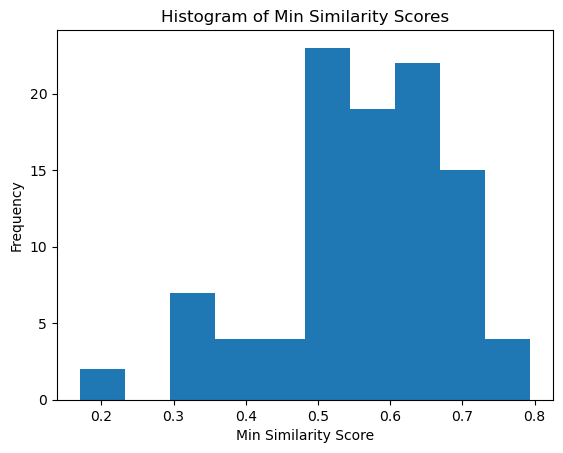

In [238]:
similarity_df["min_score"].plot(kind='hist', legend=False)
plt.title("Histogram of Min Similarity Scores")
plt.xlabel("Min Similarity Score")
plt.ylabel("Frequency")
plt.show()


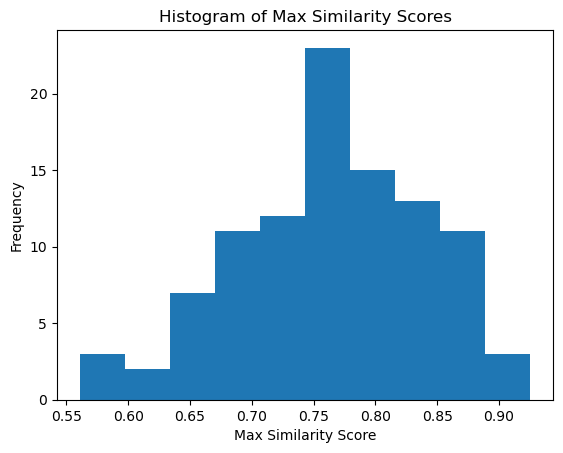

In [239]:
similarity_df["max_score"].plot(kind='hist', legend=False)
plt.title("Histogram of Max Similarity Scores")
plt.xlabel("Max Similarity Score")
plt.ylabel("Frequency")
plt.show()

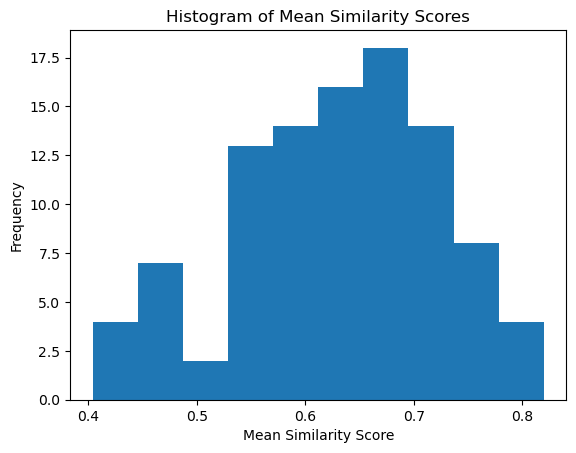

In [223]:
similarity_df["mean_score"].plot(kind='hist', legend=False)
plt.title("Histogram of Mean Similarity Scores")
plt.xlabel("Mean Similarity Score")
plt.ylabel("Frequency")
plt.show()


##  ------------- strictest filter ---------
### all receiver, department and specialty exact match

In [ ]:
from google.cloud import bigquery

# Set up logging
logger = setup_logging()

# query_message = message_content.replace("\n", "")
query_message = sampled_df.iloc[i]["Patient Message"]
query_vector_literal = query_embedding_func(query_message, embeddings_model)

# Filter criteria 
receiver = sampled_df.iloc[0]["Recipient Names"]
department = sampled_df.iloc[0]["Message Department"]
specialty = sampled_df.iloc[0]['Department Specialty Title']

query = f"""
WITH input_embedding AS (
  SELECT {query_vector_literal} AS input_vec
)

SELECT
  t.`Thread ID`,
  t.`Patient Message`,
  t.`Message Sender`,
  t.`Message Department`,
  t.`Department Specialty Title`,
  t.`Actual Response Sent to Patient`,
  (
    SELECT SUM(x * y)
    FROM UNNEST(t.embeddings) AS x WITH OFFSET i
    JOIN UNNEST(input_vec) AS y WITH OFFSET j
    ON i = j
  ) /
  (
    SQRT((SELECT SUM(POW(x, 2)) FROM UNNEST(t.embeddings) AS x)) *
    SQRT((SELECT SUM(POW(y, 2)) FROM UNNEST(input_vec) AS y))
  ) AS cosine_similarity
FROM `som-nero-phi-jonc101.rag_embedding_R01.messages_with_embeddings_pcp_only` AS t,
     input_embedding
WHERE
  t.`Recipient Names` = @receiver
  AND t.`Message Department` = @department
  AND t.`Department Specialty Title` = @specialty
ORDER BY cosine_similarity DESC
LIMIT 5
"""

job = client.query(
    query,
    job_config=bigquery.QueryJobConfig(
        query_parameters=[
            bigquery.ScalarQueryParameter("receiver", "STRING", receiver),
            bigquery.ScalarQueryParameter("department", "STRING", department),
            bigquery.ScalarQueryParameter("specialty", "STRING", specialty)
        ]
    )
)

# Log query parameters
log_query_parameters(logger, query_message, receiver, department, specialty)

# Try to get results
try:
    results = list(job.result())
    log_results(logger, results, beautiful_print_thread, answer_question_paired_data_dedup)
except Exception as e:
    log_error(logger, str(e))

## -----------Tiered Retrieval-----------

In [18]:
from google.cloud import bigquery

def run_query_bq(filter_field, filter_value, query_vector_literal, client, N, similarity_cutoff=0.7, exclude_threads=None):
    exclude_clause = ""
    params = [
        bigquery.ScalarQueryParameter("filter_value", "STRING", filter_value),
        bigquery.ScalarQueryParameter("similarity_cutoff", "FLOAT64", similarity_cutoff),
        bigquery.ScalarQueryParameter("N", "INT64", N)
    ]
    if exclude_threads and len(exclude_threads) > 0:
        # FIX: Cast to int and use INT64 type
        exclude_threads = [int(x) for x in exclude_threads]
        exclude_clause = "AND t.`Thread ID` NOT IN UNNEST(@exclude_threads)"
        params.append(bigquery.ArrayQueryParameter("exclude_threads", "INT64", exclude_threads))
    
    base_query = f"""
    WITH input_embedding AS (
      SELECT {query_vector_literal} AS input_vec
    ),
    scored_messages AS (
      SELECT
        t.`Thread ID`,
        t.`Patient Message`,
        t.`Message Sender`,
        t.`Message Department`,
        t.`Department Specialty Title`,
        t.`Actual Response Sent to Patient`,
        (
          SELECT SUM(x * y)
          FROM UNNEST(t.embeddings) AS x WITH OFFSET i
          JOIN UNNEST(input_vec) AS y WITH OFFSET j
          ON i = j
        ) /
        (
          SQRT((SELECT SUM(POW(x, 2)) FROM UNNEST(t.embeddings) AS x)) *
          SQRT((SELECT SUM(POW(y, 2)) FROM UNNEST(input_vec) AS y))
        ) AS cosine_similarity
      FROM `som-nero-phi-jonc101.rag_embedding_R01.messages_with_embeddings_pcp_only` AS t, input_embedding
      WHERE t.`{filter_field}` = @filter_value
      {exclude_clause}
    )
    SELECT *
    FROM scored_messages
    WHERE cosine_similarity >= @similarity_cutoff
    ORDER BY cosine_similarity DESC
    LIMIT @N
    """

    job = client.query(
        base_query,
        job_config=bigquery.QueryJobConfig(query_parameters=params)
    )
    return list(job.result())


def run_tiered_retrieval(query_vector_literal, receiver, department, specialty, client, target_N=5, similarity_cutoff=0.7):
    all_results = []

    # 1. Sender Level
    results = run_query_bq(
        filter_field="Recipient Names", filter_value=receiver,
        query_vector_literal=query_vector_literal,
        client=client,
        N=target_N,
        similarity_cutoff=similarity_cutoff
    )
    all_results.extend([{**dict(r), "retrieval_tier": "sender"} for r in results])

    # 2. Department Level
    if len(all_results) < target_N:
        exclude_threads = [int(r["Thread ID"]) for r in all_results]
        results = run_query_bq(
            filter_field="Message Department", filter_value=department,
            query_vector_literal=query_vector_literal,
            client=client,
            N=target_N - len(all_results),
            similarity_cutoff=similarity_cutoff,
            exclude_threads=exclude_threads
        )
        all_results.extend([{**dict(r), "retrieval_tier": "department"} for r in results])

    # 3. Specialty Level
    if len(all_results) < target_N:
        exclude_threads = [int(r["Thread ID"]) for r in all_results]
        results = run_query_bq(
            filter_field="Department Specialty Title", filter_value=specialty,
            query_vector_literal=query_vector_literal,
            client=client,
            N=target_N - len(all_results),
            similarity_cutoff=similarity_cutoff,
            exclude_threads=exclude_threads
        )
        all_results.extend([{**dict(r), "retrieval_tier": "specialty"} for r in results])

    return all_results[:target_N]


In [19]:
results = run_tiered_retrieval(
    query_vector_literal=query_vector_literal,
    receiver=receiver,
    department=department,
    specialty=specialty,
    client=client,
    target_N=10,                # Number of final results you want
    similarity_cutoff=0.7      # The minimum cosine similarity required
)


#show results
print("Query Parameters:")
print(f"query_message: {query_message}")
print(f"receiver: {receiver}")
print(f"department: {department}")
print(f"specialty: {specialty}")

try:
    print(f"\nNumber of results: {len(results)}")
    
    if len(results) > 0:
        for row in results:
            print("##" * 80)
            print(f"➡️ Similarity: {row['cosine_similarity']:.4f}")
            print(f"➡️ Message by Sender {row['Message Sender']}: {row['Patient Message']}")
            print(f"➡️ Provider's response to this specific message is: {row['Actual Response Sent to Patient']}")
            print(f"➡️ This result is from tier: {row['retrieval_tier']}")
            print("➡️ -----------printing the whole thread-------------")
            beautiful_print_thread(row["Thread ID"], answer_question_paired_data_dedup)
            print("##" * 80)
    else:
        print("No results found matching the criteria")
except Exception as e:
    print(f"Error getting results: {str(e)}")


Query Parameters:
query_message: Hi Dr. Martin,I wanted to touch base regarding my most recent blood work from earlier this month. I’ve been feeling extra fatigued and short of breath lately, and I’m a bit worried it might be related to my ongoing iron issues. Would you be able to let me know if my latest results suggest it’s time to schedule another iron infusion? Also, since I usually need an ultrasound-guided IV, should I go ahead and book that appointment too?Thanks so much for your help!Best,  Melissa
receiver: MARTIN, BETH
department: HEMATOLOGY
specialty: Hematology

Number of results: 10
################################################################################################################################################################
➡️ Similarity: 0.8124
➡️ Message by Sender APOSTOL, JENNY [ S0333370]: Hi Dr. Martin,I hope you're well! Did  you have an opportunity to review the labs my mom completed on 11/14/24?  If so, do you think she's due for an Iron Infusion a

## -----------Weighted Retrieval-----------

In [20]:
def get_personalized_score(row, receiver, department, specialty, 
                           sender_weight=0.2, dept_weight=0.1, spec_weight=0.05):
    score = row["cosine_similarity"]
    if row["Recipient Names"] == receiver:
        score += sender_weight
    elif row["Message Department"] == department:
        score += dept_weight
    elif row["Department Specialty Title"] == specialty:
        score += spec_weight
    return score

def weighted_retrieval(query_vector_literal, receiver, department, specialty, client, top_k=100, final_N=5,
                       sender_weight=0.2, dept_weight=0.1, spec_weight=0.05, similarity_cutoff=0.7):
    # Run the broad query
    base_query = f"""
    WITH input_embedding AS (
      SELECT {query_vector_literal} AS input_vec
    )
    SELECT
      t.`Thread ID`,
      t.`Patient Message`,
      t.`Message Sender`,
      t.`Recipient Names`,
      t.`Message Department`,
      t.`Department Specialty Title`,
      t.`Actual Response Sent to Patient`,
      (
        SELECT SUM(x * y)
        FROM UNNEST(t.embeddings) AS x WITH OFFSET i
        JOIN UNNEST(input_vec) AS y WITH OFFSET j
        ON i = j
      ) /
      (
        SQRT((SELECT SUM(POW(x, 2)) FROM UNNEST(t.embeddings) AS x)) *
        SQRT((SELECT SUM(POW(y, 2)) FROM UNNEST(input_vec) AS y))
      ) AS cosine_similarity
    FROM `som-nero-phi-jonc101.rag_embedding_R01.messages_with_embeddings_pcp_only` AS t, input_embedding
    ORDER BY cosine_similarity DESC
    LIMIT @K
    """
    params = [bigquery.ScalarQueryParameter("K", "INT64", top_k)]
    job = client.query(
        base_query,
        job_config=bigquery.QueryJobConfig(query_parameters=params)
    )
    rows = list(job.result())

    # Compute personalized score for each row, filter by similarity_cutoff
    scored = []
    for r in rows:
        row_dict = dict(r)
        if row_dict["cosine_similarity"] >= similarity_cutoff:
            row_dict["personalized_score"] = get_personalized_score(
                row_dict, receiver, department, specialty, 
                sender_weight, dept_weight, spec_weight
            )
            # Annotate which tier matched
            if row_dict["Recipient Names"] == receiver:
                row_dict["personalization_tier"] = "sender"
            elif row_dict["Message Department"] == department:
                row_dict["personalization_tier"] = "department"
            elif row_dict["Department Specialty Title"] == specialty:
                row_dict["personalization_tier"] = "specialty"
            else:
                row_dict["personalization_tier"] = "none"
            scored.append(row_dict)

    # Sort by personalized_score (descending)
    scored = sorted(scored, key=lambda x: x["personalized_score"], reverse=True)

    # Return top N
    return scored[:final_N]


In [ ]:
results = weighted_retrieval(
    query_vector_literal=query_vector_literal,
    receiver=receiver,
    department=department,
    specialty=specialty,
    client=client,
    top_k=100,
    final_N=5,  # Final results you want
    sender_weight=0.2,
    dept_weight=0.1,
    spec_weight=0.05,
    similarity_cutoff=0.7
)

#show results
print("Query Parameters:")
print(f"query_message: {query_message}")
print(f"receiver: {receiver}")
print(f"department: {department}")
print(f"specialty: {specialty}")

try:
    print(f"\nNumber of results: {len(results)}")
    
    if len(results) > 0:
        for row in results:
            print("##" * 80)
            print(f"[{row['personalization_tier']}] Score: {row['personalized_score']:.3f} (CosSim: {row['cosine_similarity']:.3f})")
            print(f"➡️ Message by Sender {row['Message Sender']}: {row['Patient Message']}")
            print(f"➡️ Provider's response to this specific message is: {row['Actual Response Sent to Patient']}")
            print(f"➡️ This result is from tier: {row['personalization_tier']}")
            print("➡️ -----------printing the whole thread-------------")
            beautiful_print_thread(row["Thread ID"], answer_question_paired_data_dedup)
            print("##" * 80)
    else:
        print("No results found matching the criteria")
except Exception as e:
    print(f"Error getting results: {str(e)}")


Query Parameters:
query_message: Hi Dr. Martin,I wanted to touch base regarding my most recent blood work from earlier this month. I’ve been feeling extra fatigued and short of breath lately, and I’m a bit worried it might be related to my ongoing iron issues. Would you be able to let me know if my latest results suggest it’s time to schedule another iron infusion? Also, since I usually need an ultrasound-guided IV, should I go ahead and book that appointment too?Thanks so much for your help!Best,  Melissa
receiver: MARTIN, BETH
department: HEMATOLOGY
specialty: Hematology

Number of results: 5
################################################################################################################################################################
[sender] Score: 1.012 (CosSim: 0.812)
➡️ Message by Sender APOSTOL, JENNY [ S0333370]: Hi Dr. Martin,I hope you're well! Did  you have an opportunity to review the labs my mom completed on 11/14/24?  If so, do you think she's due for an 